In [ ]:
import torch
import torch.nn as nn

directory = '/content/drive/My Drive/leapGestRecog'
output_folder = "/content/drive/My Drive/dataset_split"

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls "/content/drive/My Drive/leapGestRecog"

Mounted at /content/drive
00  01	02  03	04  05	06  07	08  09


In [ ]:
#!pip install split-folders

In [ ]:
# import os


# # Read Folders
# folders = os.listdir(directory)
# categories = {
#     category: []
#     for category in os.listdir(f"{directory}/{folders[0]}")
# }

# for folder in folders:
#   folder_dir = f"{directory}/{folder}"
#   for category in os.listdir(folder_dir):
#     categories[category] += os.listdir(f"{folder_dir}/{category}")




In [ ]:
# # Sampling Data
# import random
# from shutil import copy
# from concurrent.futures import ThreadPoolExecutor, as_completed



# def copy_category(category):
#   random.shuffle(categories[category])
#   test_limit = int(len(categories[category]) - len(categories[category]) * 0.2) # Total - Splitted

#   training = categories[category][:test_limit]
#   testing = categories[category][test_limit:]

#   main_dir = f"{directory}/"
#   test_dir = f"{output_folder}/test/"
#   train_dir = f"{output_folder}/train/"

#   os.makedirs(test_dir, exist_ok=True)
#   os.makedirs(train_dir, exist_ok=True)

#   # Copy Data
#   try:
#     for file in training:
#       file_dir = file.split("_")[1]
#       copy(f"{directory}/{file_dir}/{category}/{file}", f"{train_dir}{file_dir}/{file}")
#   # print(f"Training Set For : {category} that has : {len(training)} Images is done!")


#     for file in testing:
#       file_dir = file.split("_")[1]
#       copy(f"{directory}/{file_dir}/{category}/{file}", f"{test_dir}{file_dir}/{file}")
#   # print(f"Test Set For : {category} that has : {len(testing)} Images is done!")
#   except Exception as e:
#     print(e)


#   print(f"{category} is done!")

# with ThreadPoolExecutor(max_workers=10) as executor:  # Adjust `max_workers` based on your system's capability
#     futures = [executor.submit(copy_category, category) for category in categories]
#         # Wait for all futures to complete
#     for future in as_completed(futures):
#         try:
#             future.result()  # Ensure exceptions in threads are raised here
#         except Exception as e:
#             print(f"Error processing category: {e}")

In [ ]:
# !ls "/content/drive/My Drive/dataset_split/train/02/"

In [ ]:
class block(nn.Module):

  def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
    super(block,self).__init__()
    self.expansion = 4

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(out_channels)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
    self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)

    self.relu = nn.ReLU()
    self.identity_downsample = identity_downsample

  def forward(self, x):
    identity = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)

    x = self.conv3(x)
    x = self.bn3(x)

    if self.identity_downsample is not None:
      identity = self.identity_downsample(identity)

    x += identity
    x = self.relu(x)
    return x



In [ ]:
class ResNet(nn.Module):

  def __init__(self, block, layers, image_channels, num_classes):
    super(ResNet, self).__init__()

    self.in_channels = 64
    self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
    self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
    self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
    self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512*4, num_classes)


  def forward(self, x):
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.maxpool(x)
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      x = self.avgpool(x)
      x = x.reshape(x.shape[0], -1)
      x = self.fc(x)
      return x

  def _make_layer(self, block, num_blocks, out_channels, stride):
      identity_downsample = None
      layers = []

      if stride != 1 or self.in_channels != out_channels*4:
        identity_downsample = nn.Sequential(
            nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1, stride=stride),
            nn.BatchNorm2d(out_channels*4)
        )

      layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
      self.in_channels = out_channels*4

      for i in range(num_blocks - 1):
        layers.append(block(self.in_channels, out_channels))

      return nn.Sequential(*layers)

In [ ]:
def ResNet50(img_channels=3, num_classes=1000):
  return ResNet(block, [3,4,6,3], img_channels, num_classes)

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Flip images horizontally
    transforms.RandomRotation(10),     # Rotate images by ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color variations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Paths to datasets
train_dir = f"{output_folder}/train/"
val_dir = f"{output_folder}/test/"


# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

# DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True , num_workers=4, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False , num_workers=4, pin_memory=True)
# Increase Batch Size to stabilize gradient updates
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True , num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False , num_workers=4, pin_memory=True)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

Training samples: 15561, Validation samples: 3891


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Training Loop
import time
import torch.optim as optim
print(torch.cuda.is_available())


# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load ResNet50 model
model = ResNet50(img_channels=3, num_classes=10).to(device)



# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
start_time = time.time()
for epoch in range(10):
    epoch_start = time.time()
    running_loss = 0
    for i, (inputs, labels) in enumerate(train_loader):
        # batch_start = time.time()
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # print(f"Batch {i+1} processed in {time.time() - batch_start:.2f} seconds")

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")
    print(f"Epoch {epoch+1} completed in {time.time() - epoch_start:.2f} seconds")

print(f"Total training time: {time.time() - start_time:.2f} seconds")

True
Epoch 1, Loss: 1.1900551908131254
Epoch 1 completed in 190.94 seconds
Epoch 2, Loss: 0.2698346394701293
Epoch 2 completed in 176.94 seconds
Epoch 3, Loss: 0.13455512647582046
Epoch 3 completed in 174.28 seconds
Epoch 4, Loss: 0.10902723575439266
Epoch 4 completed in 173.80 seconds
Epoch 5, Loss: 0.06770958534362526
Epoch 5 completed in 172.32 seconds
Epoch 6, Loss: 0.043429302015687
Epoch 6 completed in 175.07 seconds
Epoch 7, Loss: 0.06711882224331385
Epoch 7 completed in 177.57 seconds
Epoch 8, Loss: 0.06660475020183444
Epoch 8 completed in 175.88 seconds
Epoch 9, Loss: 0.02705282297753651
Epoch 9 completed in 173.99 seconds
Epoch 10, Loss: 0.045155791899396086
Epoch 10 completed in 173.86 seconds
Total training time: 1764.65 seconds


In [ ]:
train_preds, train_labels = [], []

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, axis=1)

        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

train_accuracy = accuracy_score(train_labels, train_preds)
print(f"Training Accuracy: {train_accuracy}")


Training Accuracy: 0.9701818649187071


In [ ]:
# Save the entire model
torch.save(model, output_folder + "/resnet50_pretrained.pth")

# Alternatively, save just the state dictionary (recommended for larger models)
torch.save(model.state_dict(), output_folder + "/resnet50_state_dict.pth")

print("Model saved successfully!")


Model saved successfully!


In [ ]:
# Test Model - Accuracy
from sklearn.metrics import accuracy_score

model.eval()  # Set model to evaluation mode
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, axis=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {accuracy}")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Accuracy: 0.9804677460806991


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Accuracy: 0.9810


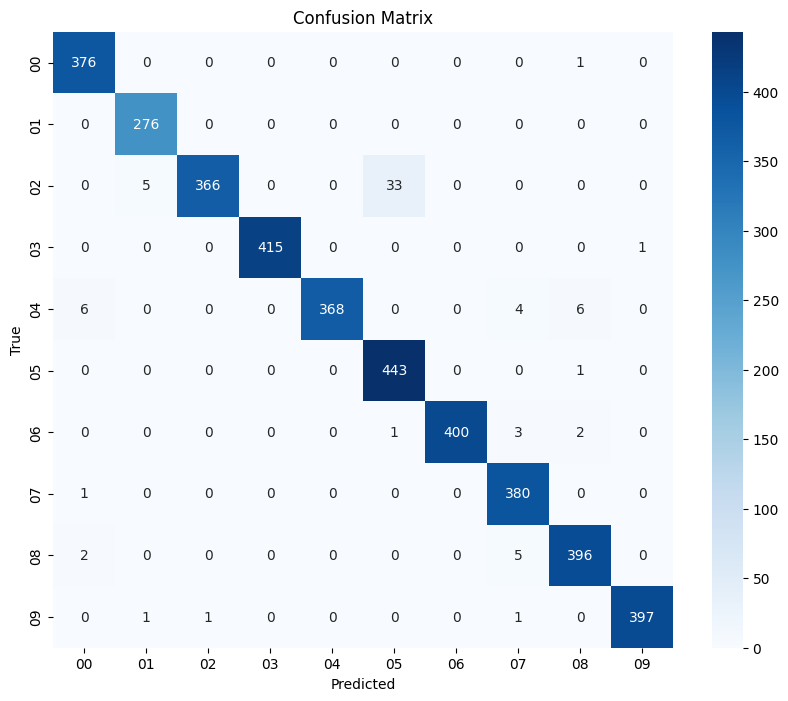

Classification Report:
              precision    recall  f1-score   support

          00       0.98      1.00      0.99       377
          01       0.98      1.00      0.99       276
          02       1.00      0.91      0.95       404
          03       1.00      1.00      1.00       416
          04       1.00      0.96      0.98       384
          05       0.93      1.00      0.96       444
          06       1.00      0.99      0.99       406
          07       0.97      1.00      0.98       381
          08       0.98      0.98      0.98       403
          09       1.00      0.99      0.99       400

    accuracy                           0.98      3891
   macro avg       0.98      0.98      0.98      3891
weighted avg       0.98      0.98      0.98      3891



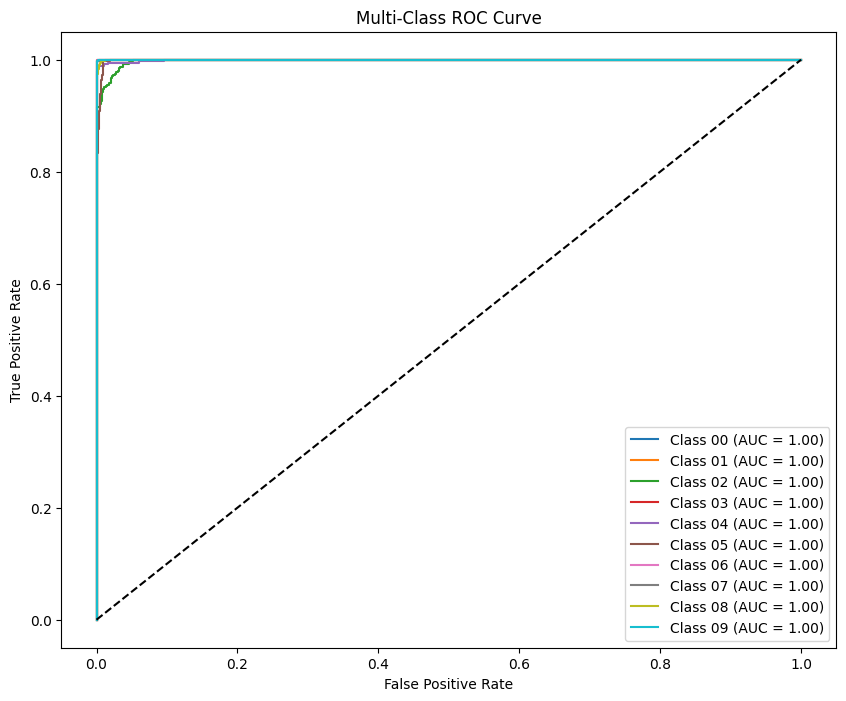

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Collect predictions and labels
model.eval()
val_preds, val_labels, val_probs = [], [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)  # Probabilities for ROC
        preds = torch.argmax(outputs, dim=1)

        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())
        val_probs.extend(probs.cpu().numpy())

val_labels_bin = label_binarize(val_labels, classes=np.arange(len(train_dataset.classes)))
val_probs = np.array(val_probs)

# Accuracy
accuracy = accuracy_score(val_labels, val_preds)
print(f"Validation Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(val_labels, val_preds, target_names=train_dataset.classes))

# ROC and AUC
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(train_dataset.classes)):
    fpr[i], tpr[i], _ = roc_curve(val_labels_bin[:, i], val_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(train_dataset.classes)):
    plt.plot(fpr[i], tpr[i], label=f"Class {train_dataset.classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc="lower right")
plt.show()
